<a href="https://colab.research.google.com/github/xghan99/dsa4212-assignments/blob/main/BaseFactorModelandStacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Google Drive Mount

In [ ]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import time

from sklearn.model_selection import train_test_split
from scipy import sparse

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Change directory here!
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


#Reading Data

In [ ]:
# Read Training Data
train_all = pd.read_csv('assignment_2_ratings_train.csv')
train_all

,user_id,anime_id,rating
0,20170,10794,6
1,24592,21995,5
2,18358,7054,10
3,59267,488,7
4,69313,30544,4
...,...,...,...
4436063,32872,15061,7
4436064,66206,20507,8
4436065,46386,834,7
4436066,10497,9159,7


In [ ]:
#Shuffle and Split
train_all_shuffled = train_all.sample(frac = 1)
train, valid = train_test_split(train_all_shuffled, test_size=0.2)

In [ ]:
#Convert to JAX numpy arrays
train_np = jnp.array(train)
val_np = jnp.array(valid)

# Compute Averages by User and Anime


In [ ]:
#Compute Average by Anime
train_avg_by_anime = train.groupby('anime_id')[['rating']].mean()
train_avg_by_anime.head()

,rating
anime_id,
1,8.871604
5,8.444582
6,8.427568
7,7.516502
8,7.122905


In [ ]:
#Compute Average by User
train_avg_by_user = train.groupby('user_id')[['rating']].mean()
train_avg_by_user.head()

,rating
user_id,
1,10.000000
3,7.528302
5,4.520000
7,7.358289
8,7.000000


# Building Standard Factor Model for Ratings

We build a standard factor model to generate predictions for the ratings. We aim to optimise 2 matrices U and V such that the original user-anime matrix $M ≈ UV$ , where $U \in \mathbb{R}^{p,r}$ and $V \in \mathbb{R}^{r,q}$, for r latent features.



In [ ]:
#Getting the columns from training set
train_user_id, train_anime_id , train_actual_ratings = train_np[:,0],train_np[:,1],train_np[:,2]

In [ ]:
#Generating the list of unique User and Anime IDs
train_user_id_all = list(set(train_avg_by_user.index))
train_anime_id_all = list(set(train_avg_by_anime.index))

In [ ]:
#Generating Dimension of Matrices, +1 to avoid index errors
p = max(train_user_id_all) + 1
q = max(train_anime_id_all) + 1
r = 10
print(p,q)

73517 34476


In [ ]:
# Initialise U and V, check below for proper intialization
U_init = np.random.normal(1,0.4,size = (p,r))
V_init = np.random.normal(1,0.4,size = (q,r))

## Tuning Initialisation Parameters

In [ ]:
#Ratings computed by U_init and V_init
initial_ratings = jnp.sum(U_init[train_user_id]*V_init[train_anime_id], axis = 1)

(array([ 11.,  13.,  23.,  39., 138., 296., 642., 755., 630., 453.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

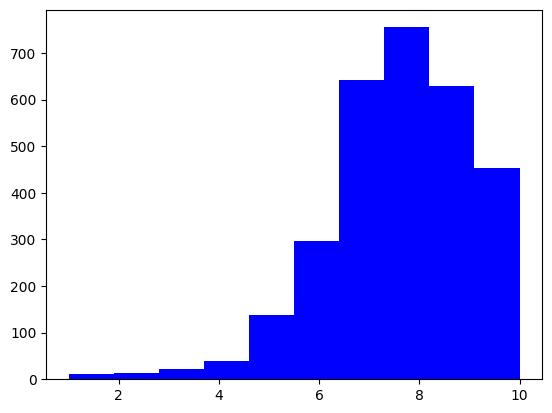

In [ ]:
#Plotting histogram of ratings from a sample of the training dataset
sample = np.random.randint(0, len(train_actual_ratings),3000)
plt.hist(train_actual_ratings[sample], color = "blue")


(array([ 11.,  99., 370., 682., 824., 587., 288., 111.,  20.,   8.]),
 array([ 4.25709057,  5.54411411,  6.83113766,  8.1181612 ,  9.40518475,
        10.69220924, 11.97923279, 13.26625633, 14.55327988, 15.84030342,
        17.12732697]),
 <BarContainer object of 10 artists>)

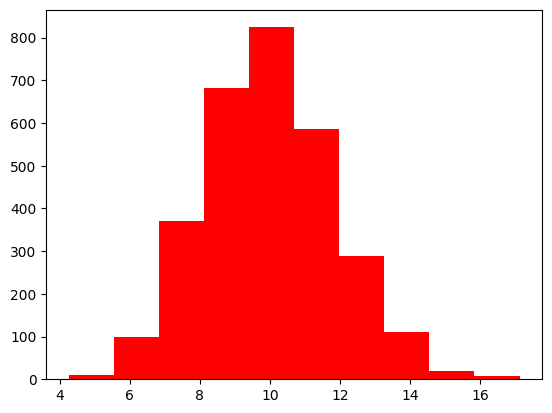

In [ ]:
#Plotting histogram of predicted ratings from the same sample from dot product of U_init and V_init
plt.hist(initial_ratings[sample], color = "red")

Majority of the Initial Predicted Ratings are around 8 - 10, so this initialization is acceptable

## Train Factor Model

In [ ]:
#Loss functions
all_u = np.array(train_user_id_all)
all_v = np.array(train_anime_id_all)
lamb = 128
#MSE Loss with L2 Reg
@jax.jit
def reg_loss(U,V,u_list,f_list,actual_ratings):
  pred_ratings = jnp.sum(U[u_list]*V[f_list], axis = 1)
  constraint = (1/(len(all_u)*10))*jnp.linalg.norm(U[all_u]) + (1/(len(all_v)*10))*jnp.linalg.norm(V[all_v])
  return jnp.mean((pred_ratings-actual_ratings)**2) + lamb*constraint
#Normal MSE (for monitoring train and valid MSE at each epoch)
@jax.jit
def loss(U,V,u_list,f_list,actual_ratings):
  pred_ratings = jnp.sum(U[u_list]*V[f_list], axis = 1)
  return jnp.mean((pred_ratings-actual_ratings)**2)

In [ ]:
#Gradient Functions
U_grad = jax.jit(jax.grad(reg_loss, argnums = 0))
V_grad = jax.jit(jax.grad(reg_loss, argnums = 1))

In [ ]:
#Getting columns from validation set
valid_user_id, valid_anime_id, valid_rating = np.array(val_np[:,0]), np.array(val_np[:,1]), np.array(val_np[:,2])

In [ ]:
#getting set of unique user and anime ids
user_set = set(train_avg_by_user.index) 
anime_set = set(train_avg_by_anime.index)

In [ ]:
#returns 4 lists(categories), each containing index of x that belongs in the specified category
def split_category(x, user_set, anime_set):
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  in_both = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] in anime_set])
  in_user = np.array([i for i in range(len(x)) if user_id[i] in user_set and anime_id[i] not in anime_set])
  in_anime = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] in anime_set])
  in_none = np.array([i for i in range(len(x)) if user_id[i] not in user_set and anime_id[i] not in anime_set])
  return in_both, in_user, in_anime, in_none

In [ ]:
#Splits validation set into the 4 categories
in_both, in_user, in_anime, in_none = split_category(val_np, user_set, anime_set)

In [ ]:
#Sanity Check that the 4 categories are mutually exclusive
len(in_both) + len(in_user) + len(in_anime) + len(in_none) - len(val_np)

0

In [ ]:
#Verify that no entry in the validation set is in_none
len(in_none)

0

In [ ]:
#Create validation batch (to be used in the training loop) using 1st category (in_both)
#simpler computation as both user and anime id exist in the training set for this category
val_batch_user_id = valid_user_id[in_both]
val_batch_anime_id = valid_anime_id[in_both]
val_batch_ratings = valid_rating[in_both]

In [ ]:
#Copy U and V
U = jnp.array(np.copy(U_init))
V = jnp.array(np.copy(U_init))

In [ ]:
#training loop
epochs = 50
batch_size = 8192
lr = 0.8
trloss_traj = []
val_loss_traj = []
#For momentum calculation
change_u = None
change_v = None
for i in range(epochs):
  batches = jnp.arange((train_np.shape[0]//batch_size)+1)
  for batch in tqdm(batches):
    if batch != batches[-1]:
      start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
    else:
      start, end = int(batch*batch_size), None
    u_list = train_user_id[start:end]
    f_list = train_anime_id[start:end]
    actual_ratings = jnp.array(train_actual_ratings[start:end])
    #Compute Gradients
    u_g  = U_grad(U,V,u_list,f_list,actual_ratings)
    v_g = V_grad(U,V,u_list,f_list,actual_ratings)
    if change_u == None and change_v == None:
      #No momentum updates on first iteration
      U = U - lr*u_g
      V = V - lr*v_g 
      change_u = lr*u_g
      change_v = lr*v_g
    else:
      #SGD with 0.9*momentum
      U = U - lr*u_g - 0.9*change_u
      V = V - lr*v_g - 0.9*change_v
      change_u = lr*u_g + 0.9*change_u
      change_v = lr*v_g + 0.9*change_v
  
  print(f"epoch:{i}")
  #Compute Training Loss on a single training batch of size 512
  u_list = train_user_id[0:512]
  f_list = train_anime_id[0:512]
  actual_ratings = jnp.array(train_actual_ratings[0:512])
  tr_loss = loss(U,V, u_list,f_list,actual_ratings)
  print(f"training loss: {tr_loss}")
  trloss_traj.append(tr_loss)

  #Compute Validation Loss on a single validation batch of size 512
  u_list = val_batch_user_id[0:512]
  f_list = val_batch_anime_id[0:512]
  actual_ratings = jnp.array(val_batch_ratings[0:512])
  val_loss = loss(U,V, u_list,f_list,actual_ratings)
  print(f"val loss: {val_loss}")
  val_loss_traj.append(val_loss)

  0%|          | 0/434 [00:00<?, ?it/s]

epoch:0
training loss: 2.0511789321899414
val loss: 1.9307341575622559


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:1
training loss: 1.8421969413757324
val loss: 1.715815782546997


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:2
training loss: 1.7613842487335205
val loss: 1.6479653120040894


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:3
training loss: 1.7160730361938477
val loss: 1.6180044412612915


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:4
training loss: 1.6869704723358154
val loss: 1.6018290519714355


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:5
training loss: 1.6670153141021729
val loss: 1.5917689800262451


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:6
training loss: 1.6527373790740967
val loss: 1.5848414897918701


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:7
training loss: 1.6421699523925781
val loss: 1.5797152519226074


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:8
training loss: 1.6341021060943604
val loss: 1.5757240056991577


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:9
training loss: 1.6277456283569336
val loss: 1.5725030899047852


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:10
training loss: 1.622560739517212
val loss: 1.569833755493164


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:11
training loss: 1.6181596517562866
val loss: 1.5675692558288574


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:12
training loss: 1.6142523288726807
val loss: 1.5656020641326904


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:13
training loss: 1.6106107234954834
val loss: 1.5638384819030762


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:14
training loss: 1.6070520877838135
val loss: 1.5621912479400635


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:15
training loss: 1.603431224822998
val loss: 1.560575246810913


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:16
training loss: 1.5996356010437012
val loss: 1.5589075088500977


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:17
training loss: 1.5955899953842163
val loss: 1.5571153163909912


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:18
training loss: 1.5912621021270752
val loss: 1.5551486015319824


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:19
training loss: 1.586660623550415
val loss: 1.5529881715774536


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:20
training loss: 1.5818299055099487
val loss: 1.5506548881530762


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:21
training loss: 1.5768319368362427
val loss: 1.5482006072998047


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:22
training loss: 1.5717275142669678
val loss: 1.5456931591033936


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:23
training loss: 1.5665645599365234
val loss: 1.54319429397583


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:24
training loss: 1.5613783597946167
val loss: 1.5407472848892212


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:25
training loss: 1.556198000907898
val loss: 1.538371205329895


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:26
training loss: 1.5510520935058594
val loss: 1.5360671281814575


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:27
training loss: 1.5459731817245483
val loss: 1.5338242053985596


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:28
training loss: 1.540991187095642
val loss: 1.53163480758667


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:29
training loss: 1.5361323356628418
val loss: 1.5294910669326782


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:30
training loss: 1.5314171314239502
val loss: 1.527397632598877


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:31
training loss: 1.5268577337265015
val loss: 1.525360107421875


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:32
training loss: 1.5224579572677612
val loss: 1.5233895778656006


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:33
training loss: 1.5182133913040161
val loss: 1.521498203277588


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:34
training loss: 1.5141181945800781
val loss: 1.5196987390518188


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:35
training loss: 1.5101606845855713
val loss: 1.518000602722168


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:36
training loss: 1.5063297748565674
val loss: 1.5164101123809814


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:37
training loss: 1.5026135444641113
val loss: 1.514930009841919


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:38
training loss: 1.4990004301071167
val loss: 1.5135611295700073


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:39
training loss: 1.495481252670288
val loss: 1.5122981071472168


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:40
training loss: 1.4920463562011719
val loss: 1.511134386062622


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:41
training loss: 1.4886882305145264
val loss: 1.5100609064102173


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:42
training loss: 1.4853994846343994
val loss: 1.5090657472610474


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:43
training loss: 1.4821735620498657
val loss: 1.5081374645233154


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:44
training loss: 1.4790072441101074
val loss: 1.5072603225708008


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:45
training loss: 1.4758970737457275
val loss: 1.5064220428466797


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:46
training loss: 1.472839593887329
val loss: 1.5056095123291016


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:47
training loss: 1.4698330163955688
val loss: 1.5048091411590576


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:48
training loss: 1.46687650680542
val loss: 1.5040106773376465


  0%|          | 0/434 [00:00<?, ?it/s]

epoch:49
training loss: 1.4639681577682495
val loss: 1.50320303440094


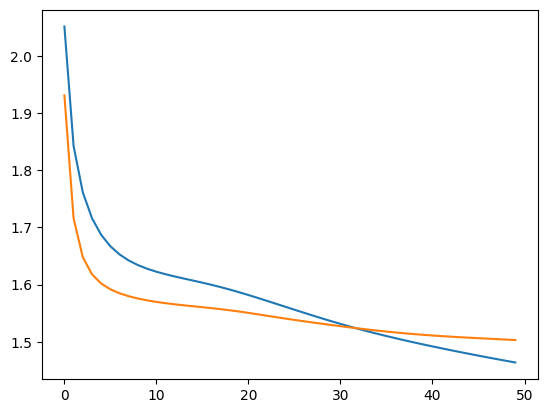

In [ ]:
#Plotting Training and Validation Loss at each epoch
plt.plot(trloss_traj)
plt.plot(val_loss_traj)

In [ ]:
#Getting Mean Factors (ignore rows that do not belong to any anime, user in the training set)
rel_U = U[all_u]
rel_V = V[all_v]
mean_user_factor = jnp.mean(rel_U, axis = 0)
mean_anime_factor = jnp.mean(rel_V, axis = 0)

In [ ]:
#Compute Global Mean
jnp.mean(train_actual_ratings)

Array(7.8089566, dtype=float32)

In [ ]:
#Sanity Check for dot product of Mean Factors, should be close to global mean.
#Due to L2 reg, it is smaller than the global mean
jnp.sum(mean_user_factor * mean_anime_factor)

Array(6.3787885, dtype=float32)

## Evaluating Standard Factor Model on Full Validation Set

In [ ]:
#Checking range of ratings in the train set
min(train['rating']),max(train['rating'])

(1, 10)

In [ ]:
#in_none is left out as it is empty
#Predictions below 1 and above 10 are set to 1 and 10 respectively using the clip method
#For in_user and in_anime, the mean factors are used as a substitute to compute the predictions
def factor_valid_mse(x, in_both, in_user, in_anime):
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  squared_error = 0
  if len(in_both)>0:
    pred_both = jnp.sum(U[user_id[in_both]]*V[anime_id[in_both]], axis = 1)
    pred_both = jnp.clip(pred_both,1,10)
    squared_error += jnp.sum((pred_both-np.array(rating[in_both]))**2)
  #Pred for in User only
  if len(in_user)>0:
    pred_user = jnp.sum(U[user_id[in_user]]*mean_anime_factor, axis = 1)
    pred_user = jnp.clip(pred_user,1,10)
    squared_error += jnp.sum((pred_user-np.array(rating[in_user]))**2)
  #Pred for in Anime only
  if len(in_anime)>0:
    pred_anime = jnp.sum(V[anime_id[in_anime]]*mean_user_factor, axis = 1)
    pred_anime = jnp.clip(pred_anime,1,10)
    squared_error += jnp.sum((pred_anime-np.array(rating[in_anime]))**2)
  return squared_error/len(x)

In [ ]:
factor_valid_mse(val_np, in_both, in_user , in_anime )

Array(1.4257646, dtype=float32)

# Triple model stacking

We aim to improve the performance of the Factor Model by Ensembling/Stacking it with the User Average and Anime Average Model. We therefore want to optimise the coefficients $a$, $b$, $c$, $d$ such that $a * User Average + b * Anime Average + c*Factor Model Prediction + d$ would provide the best prediction for ratings.

In [ ]:
#Define Loss Function
def loss(params, x):
  user_ids, anime_ids, ratings = x[:,0], x[:,1], x[:,2]
  a,b,c,d = params[0],params[1],params[2],params[3]
  avg_user = jnp.array(train_avg_by_user.loc[user_ids,].rating)
  avg_anime = jnp.array(train_avg_by_anime.loc[anime_ids,].rating)
  factor_model = jnp.sum(U[user_ids]*V[anime_ids], axis = 1)
  pred = a*avg_user + b*avg_anime + c*factor_model + d
  return jnp.mean((pred-ratings)**2)

#Differentiate with respect to params = [a,b,c,d]
loss_value_and_grad = jax.value_and_grad(loss)

In [ ]:
#Initialise a,b,c,d
params_init = np.random.normal(0.5,0.1,(4,))

In [ ]:
#Validation Batch for training loop
val_batch = val_np[in_both]

In [ ]:
params = np.copy(params_init)

#Initialisation for ADAM
value, grad = loss_value_and_grad(params, train_np)
g1 = np.copy(grad)
g2 = np.copy(grad**2)

#Hyperparameters
niter = 17
eta = 0.001
batch_size = 32768

#Tracking
tr_loss_traj = []
val_loss_traj = []

#ADAM Hyperparameters
beta1 = 0.9
beta2 = 0.99
eps = 10**-5

for i in range(niter):
  batches = jnp.arange((train_np.shape[0]//batch_size)+1)
  for batch in tqdm(batches):
    if batch != batches[-1]:
      start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
    else:
      start, end = int(batch*batch_size), None

    v,g = loss_value_and_grad(params, train_np[start:end])
    #Update Params with ADAM algorithm
    g1 = beta1*g1 + (1-beta1)*g
    g2 = beta2*g2 + (1-beta2)*(g**2)
    g_normalized = g1/(jnp.sqrt(g2)+eps)
    params = params - eta*g_normalized
  
  print(f"epoch:{i}")
  #Compute Training Loss on a single batch
  tr_loss = loss(params,train_np[0:512])
  print(f"training loss: {tr_loss}")
  tr_loss_traj.append(tr_loss)

  #Compute Validation Loss on a single batch
  val_loss = loss(params, val_batch[0:512])
  print(f"val loss: {val_loss}")
  val_loss_traj.append(val_loss)

  0%|          | 0/109 [00:00<?, ?it/s]

epoch:0
training loss: 6.563432693481445
val loss: 6.352163314819336


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:1
training loss: 2.4857027530670166
val loss: 2.3104019165039062


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:2
training loss: 1.835456371307373
val loss: 1.6884887218475342


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:3
training loss: 1.7966609001159668
val loss: 1.6568857431411743


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:4
training loss: 1.7904421091079712
val loss: 1.652626395225525


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:5
training loss: 1.7807269096374512
val loss: 1.6459994316101074


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:6
training loss: 1.764883041381836
val loss: 1.635242223739624


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:7
training loss: 1.7401344776153564
val loss: 1.6185756921768188


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:8
training loss: 1.704040288925171
val loss: 1.594597578048706


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:9
training loss: 1.657564401626587
val loss: 1.5644464492797852


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:10
training loss: 1.6078286170959473
val loss: 1.5336127281188965


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:11
training loss: 1.56337308883667
val loss: 1.5083506107330322


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:12
training loss: 1.5276530981063843
val loss: 1.4908076524734497


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:13
training loss: 1.502824068069458
val loss: 1.4818217754364014


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:14
training loss: 1.4870692491531372
val loss: 1.4791077375411987


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:15
training loss: 1.4775326251983643
val loss: 1.4796597957611084


  0%|          | 0/109 [00:00<?, ?it/s]

epoch:16
training loss: 1.4719215631484985
val loss: 1.4813823699951172


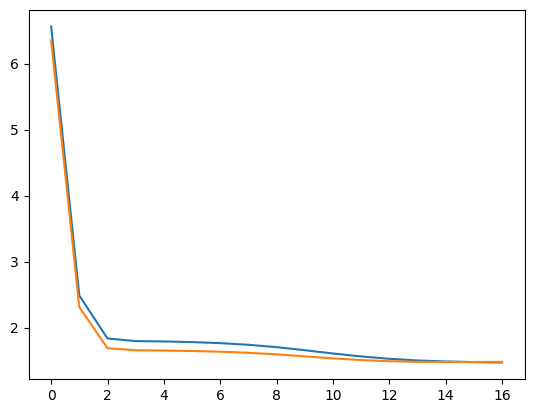

In [ ]:
#Plotting Training and Validation Loss Curves
plt.plot(tr_loss_traj)
plt.plot(val_loss_traj)

In [ ]:
#Checking Parameters
params

Array([ 0.11115871,  0.06504007,  0.8914548 , -0.51614976], dtype=float32)

In [ ]:
#Getting Global Average (Substitute in cases where User Average or Anime Average doesn't exist for that specific id)
global_avg_rating = jnp.mean(train_np[:,2])

In [ ]:
#Computing Validation Loss (MSE)
def stack_valid_mse(x, in_both, in_user, in_anime, params):
  a,b,c,d = params[0],params[1],params[2],params[3]
  user_id, anime_id, rating = np.array(x[:,0]), np.array(x[:,1]), np.array(x[:,2])
  squared_error = 0
  if len(in_both)>0:
    factor_both = jnp.sum(U[user_id[in_both]]*V[anime_id[in_both]], axis = 1)
    pred_both = jnp.array(train_avg_by_user.loc[user_id[in_both],].rating)*a + jnp.array(train_avg_by_anime.loc[anime_id[in_both],].rating)*b + c*factor_both + d
    pred_both = jnp.clip(pred_both,1,10)
    squared_error += jnp.sum((pred_both-np.array(rating[in_both]))**2)
  #Pred in User only
  if len(in_user)>0:
    factor_user = jnp.sum(U[user_id[in_user]]*mean_anime_factor, axis = 1)
    pred_user = jnp.array(train_avg_by_user.loc[user_id[in_user],].rating)*a + global_avg_rating*b + c*factor_user + d
    pred_user = jnp.clip(pred_user,1,10)
    squared_error += jnp.sum((pred_user-np.array(rating[in_user]))**2)
  #Pred in Anime only
  if len(in_anime)>0:
    factor_anime = jnp.sum(V[anime_id[in_anime]]*mean_user_factor, axis = 1)
    pred_anime = global_avg_rating*a + jnp.array(train_avg_by_anime.loc[anime_id[in_anime],].rating)*b + c*factor_anime + d
    pred_anime = jnp.clip(pred_anime,1,10)
    squared_error += jnp.sum((pred_anime-np.array(rating[in_anime]))**2)
  return squared_error/len(x)

In [ ]:
stack_valid_mse(val_np, in_both, in_user,in_anime, params)

Array(1.4135402, dtype=float32)

Stacking the 3 models together has marginally improved the performance relative to simply using the factor model.